**IMPORT REQUIRED LIBRARIES**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")


**LOAD THE TWO DATASET**

In [5]:
app = pd.read_csv("application_record.csv")
credit = pd.read_csv("credit_record.csv")
print(app.shape)
print(credit.shape)


(438557, 18)
(1048575, 3)


**CREATE TARGET VARIABLE FROM CREDIT RECORD**

In [6]:
credit['STATUS'] = credit['STATUS'].replace({
    'C': 0,
    '0': 0,
    '1': 1,
    '2': 1,
    '3': 1,
    '4': 1,
    '5': 1
})


**AGGREGATE CREDIT RECORD PER CUSTOMER**

In [8]:
credit['STATUS'] = credit['STATUS'].replace('X', 0)
credit['STATUS'] = pd.to_numeric(credit['STATUS'], errors='coerce')

credit_summary = credit.groupby('ID')['STATUS'].max().reset_index()
credit_summary.rename(columns={'STATUS': 'Approved'}, inplace=True)

**MERGE APPLICATION AND CREDIT RECORD**

In [9]:
data = pd.merge(app, credit_summary, on='ID', how='inner')
data.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Approved
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


**DROP UNNECESSARY COLUMN**

In [10]:
data.drop(['ID'], axis=1, inplace=True)


**HANDLE MISSING VALUES**

In [11]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)


**ENCODE CATEGORICAL FEATURES**

In [12]:
le = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col])


**FEATURE AND TARGET SPLIT**

In [13]:
X = data.drop('Approved', axis=1)
y = data['Approved']


**CLASS DISTRIBUTION GRAPH**

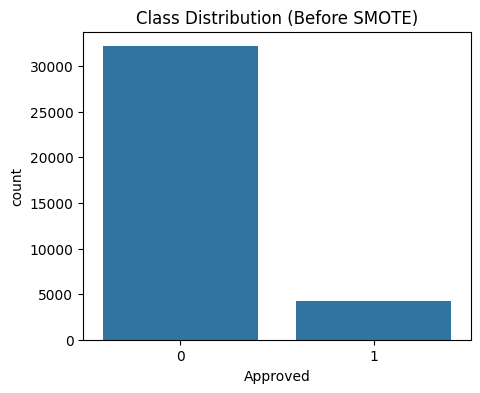

In [14]:
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Class Distribution (Before SMOTE)")
plt.show()


**HANDLE IMBALANCED DATASET**

In [16]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


**CLASS DISTRIBUTION AFTER SMOTE**

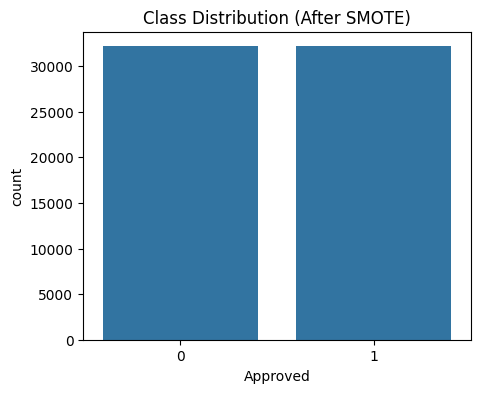

In [17]:
plt.figure(figsize=(5,4))
sns.countplot(x=y_res)
plt.title("Class Distribution (After SMOTE)")
plt.show()


**TRAIN TEST SPLIT**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)


**FEATURE SCALING**

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**MACHINE LEARNING MODELS**

In [20]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


**TRAIN AND EVALUATE MODELS**

In [21]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))



Logistic Regression
Accuracy: 0.6361234164918007
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6388
           1       0.64      0.63      0.63      6479

    accuracy                           0.64     12867
   macro avg       0.64      0.64      0.64     12867
weighted avg       0.64      0.64      0.64     12867


Decision Tree
Accuracy: 0.8974897023393177
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6388
           1       0.90      0.89      0.90      6479

    accuracy                           0.90     12867
   macro avg       0.90      0.90      0.90     12867
weighted avg       0.90      0.90      0.90     12867


Random Forest
Accuracy: 0.9137328048496153
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6388
           1       0.91      0.91      0.91      6479

    accuracy                           0.91 

**ACCURACY COMPARISON GRAPH**

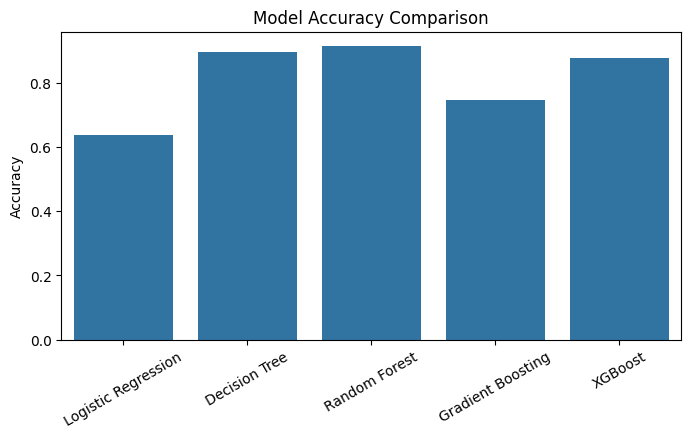

In [22]:
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30)
plt.ylabel("Accuracy")
plt.show()


**RANDOM FOREST MODEL**

In [23]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


**CONFUSION MATRIX**

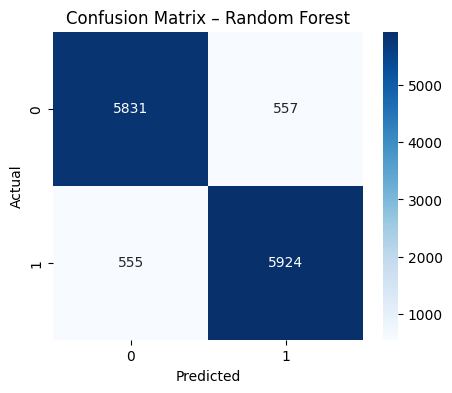

In [24]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**FEATURE IMPORTANCE**

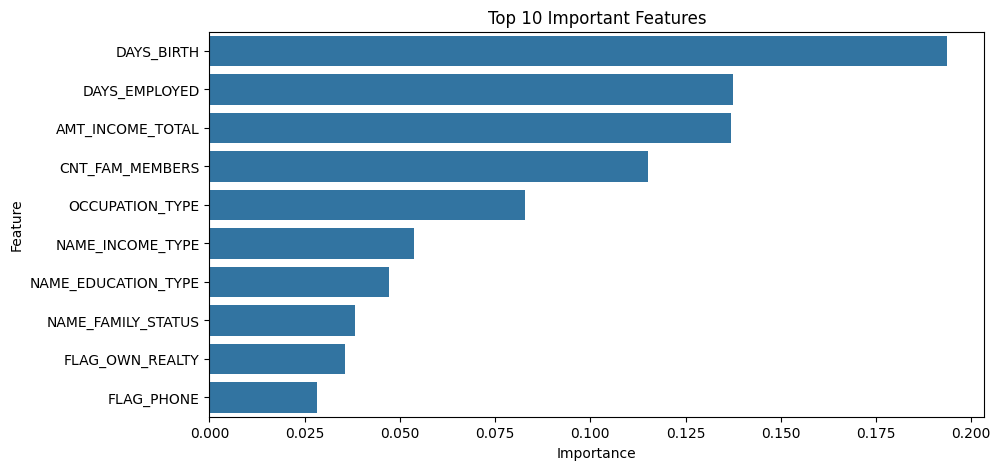

In [25]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Top 10 Important Features")
plt.show()


**FAIRNESS ANALYSIS**

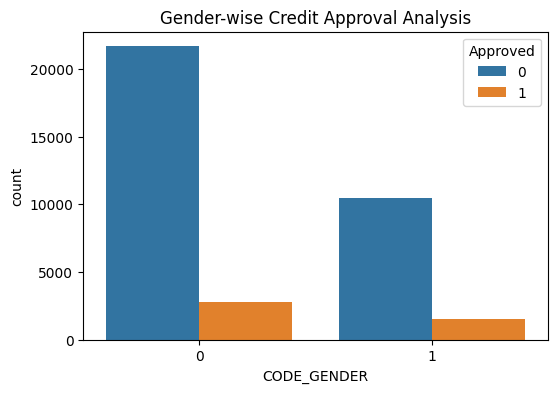

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x="CODE_GENDER", hue="Approved", data=data)
plt.title("Gender-wise Credit Approval Analysis")
plt.show()


**INTERACTIVE PREDICTION**

In [27]:
def credit_card_prediction(input_data):
    input_df = pd.DataFrame([input_data], columns=X.columns)
    input_scaled = scaler.transform(input_df)
    result = rf.predict(input_scaled)
    return "Approved" if result[0] == 1 else "Rejected"


**EXAMPLE**

In [28]:
sample_input = X.iloc[0].values
print("Prediction:", credit_card_prediction(sample_input))


Prediction: Approved
